In [36]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2
from google.colab.patches import cv2_imshow

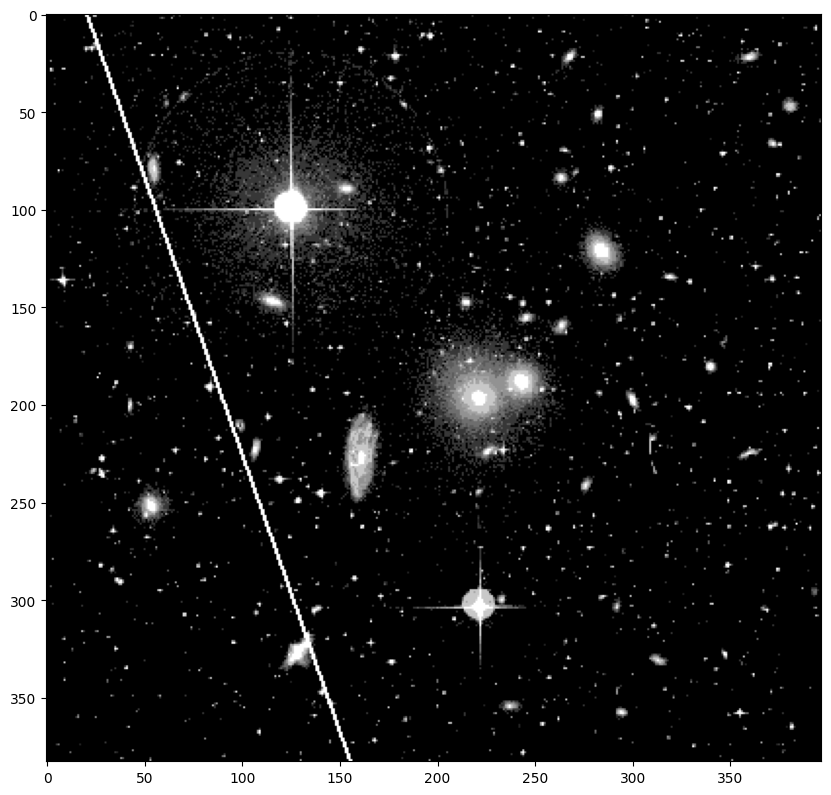

In [37]:
file_path = "hydra_poss.gif"
I_clean_1 = Image.open(file_path)
I_clean = I_clean_1.convert('L')
draw = ImageDraw.Draw(I_clean)

line_color = 255

#coordinates of the line
x1, y1 = 20 , 0
x2, y2 = 160, 397

draw.line((x1, y1, x2, y2), fill=line_color, width=2)

I_trail = np.array(I_clean, dtype=np.float32)

fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(I_trail,cmap="gray")

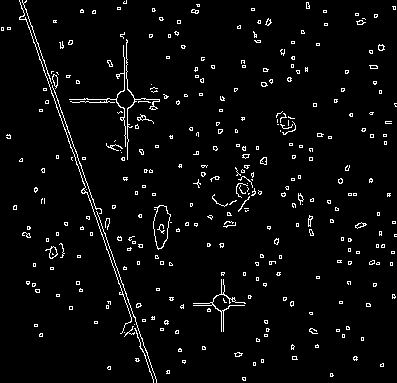

In [38]:
blur_img = cv2.GaussianBlur(I_trail, (5, 5), 0)
I_trail_1 = np.uint8(blur_img)
canny_img = cv2.Canny(I_trail_1, 100, 200)
cv2_imshow(canny_img)

In [49]:
def hough_line(img, angle_step=1, lines_are_white=True, value_threshold=5):
    """
    Hough transform for lines
    Input:
    img - 2D binary image with nonzeros representing edges
    angle_step - Spacing between angles to use every n-th angle
                 between -90 and 90 degrees. Default step is 1.
    lines_are_white - boolean indicating whether lines to be detected are white
    value_threshold - Pixel values above or below the value_threshold are edges
    Returns:
    accumulator - 2D array of the hough transform accumulator
    theta - array of angles used in computation, in radians.
    rhos - array of rho values. Max size is 2 times the diagonal
           distance of the input image.
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    width, height = img.shape
    diag_len = int(round(np.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    are_edges = 0#img > value_threshold if lines_are_white else img < value_threshold
    if lines_are_white:
      are_edges = img>value_threshold
    else:
      are_edges = img<value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

In [50]:
accumulator, thetas, rhos = hough_line(canny_img)

# Find maximum value in accumulator array
max_value_idx = np.argmax(accumulator)
max_rho_idx, max_theta_idx = np.unravel_index(max_value_idx, accumulator.shape)
max_rho, max_theta = rhos[max_rho_idx], thetas[max_theta_idx]

# Print detected line
print(f"Detected line: rho={max_rho}, theta={np.rad2deg(max_theta)}")

Detected line: rho=17.51586582048958, theta=-20.0


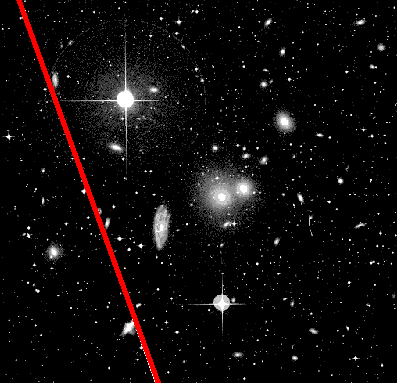

In [51]:
x1 = 0
y1 = int((max_rho - x1 * np.cos(max_theta)) / np.sin(max_theta))
x2 = I_trail.shape[1]
y2 = int((max_rho - x2 * np.cos(max_theta)) / np.sin(max_theta))

# Draw line on image
img_with_line = cv2.cvtColor(I_trail, cv2.COLOR_GRAY2BGR)
cv2.line(img_with_line, (x1, y1), (x2, y2), (0, 0, 255), 4)


cv2_imshow(img_with_line)
cv2.waitKey(0)
cv2.destroyAllWindows()

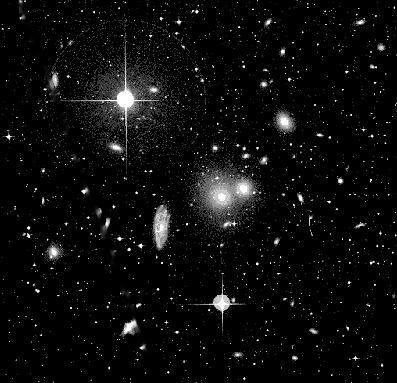

In [52]:
mask = np.uint8(np.zeros_like(I_trail))
cv2.line(mask, (x1, y1), (x2, y2), 255, 5)

# Apply inpainting algorithm to remove line
img_without_line = cv2.inpaint(I_trail, mask, 3, cv2.INPAINT_NS)


# Show image with detected line removed
cv2_imshow(img_without_line)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [53]:
def Gaussian2D(x,y,mu,sigma):
    t2 = np.exp(-1*(pow(x-mu,2) + pow(y-mu,2))/(2*pow(sigma,2)))
    t1 = 1/(2*np.pi*sigma*sigma)
    return t1*t2
def GaussianFilter(Size,StdDev):
    # Assuming the filter has values of 2D gaussian function in all 4-Directions.
    # So, center of filter should have the gaussian peak.
    mu = int((Size)/2)
    sigma = StdDev
    Filter = np.zeros((Size,Size))
    
    for i in range(Size):
        for j in range(Size):
            Filter[i][j] = Gaussian2D(i,j,mu,sigma)
            
    return Filter 

In [54]:
def padding(I1,I2):
    n1,m1 = I1.shape
    m2,n2 = I2.shape
    
    I1_Padded = np.zeros((n1+11,m1+11))
    #I2_Padded = np.zeros((m+m,m+m))
    
    I1_Padded[:n1,:m1] = I1
    #I2_Padded[:m,:m] = I2
    
    return I1_Padded#I2_Padded

In [55]:
def ssim(img1,img2,K1=0.01,K2=0.03,L=255,window_size=5,sigma = 2):
  assert img1.shape == img2.shape
  C1 = ((K1*L)**2)
  C2 = ((K2*L)**2)
  C3 = C2/2
  guassian = GaussianFilter(window_size,sigma)
  #guassian = np.zeros((window_size,window_size))
  # for i in range(window_size):
  #   for j in range(window_size):
  #     guassian[i][j] = np.exp(-((i-window_size//2)**2)+((j-window_size//2)**2))/(2*np.pi*sigma**2)
  # guassian /= np.sum(guassian)
  img1_padded = padding(img1,guassian)
  img2_padded = padding(img2,guassian)
  #SSIM = np.zeros((img1.shape[0],img1.shape[1]))
  n,m = img1.shape
  LIJ, CIJ, SIJ, SSIM = np.zeros((n,m)), np.zeros((n,m)), np.zeros((n,m)), np.zeros((n,m))

  mu_I, mu_J, sig_I,sig_J ,sig_IJ = np.zeros((n,m)),np.zeros((n,m)),np.zeros((n,m)),np.zeros((n,m)),np.zeros((n,m))
  for i in range(n):
    for j in range(m):
      mu_I[i][j] = np.sum(np.multiply(guassian, img1_padded[i : i+5, j : j+5]))
      mu_J[i][j] = np.sum(np.multiply(guassian, img2_padded[i : i+5, j : j+5])) 
      sig_I[i][j] = np.sqrt(np.sum(np.multiply(guassian, np.power(img1_padded[i : i+5, j : j+5] - mu_I[i][j], 2))))
      sig_J[i][j] = np.sqrt(np.sum(np.multiply(guassian, np.power(img2_padded[i : i+5, j : j+5] - mu_J[i][j], 2))))
      sig_IJ[i][j] = np.sum(guassian*(img1_padded[i: i+5,j: j+5] - mu_I[i][j])*(img2_padded[i: i+5,j: j+5] - mu_J[i][j]))
          
      LIJ[i][j] = (2*mu_I[i][j]*mu_J[i][j] + C1)/(mu_I[i][j]**2 + mu_J[i][j]**2 + C1)
      CIJ[i][j] = (2*sig_I[i][j]*sig_J[i][j] + C2)/(sig_I[i][j]**2 + sig_J[i][j]**2 + C2)
      SIJ[i][j] = (sig_IJ[i][j] + C3)/(sig_I[i][j]*sig_J[i][j] + C3)
            
      SSIM[i][j] = LIJ[i][j] * CIJ[i][j] * SIJ[i][j]

  MSSIM = np.mean(SSIM)
  return MSSIM, SSIM


In [56]:
MSSIM, SSIM_map = ssim(I_trail,img_without_line)

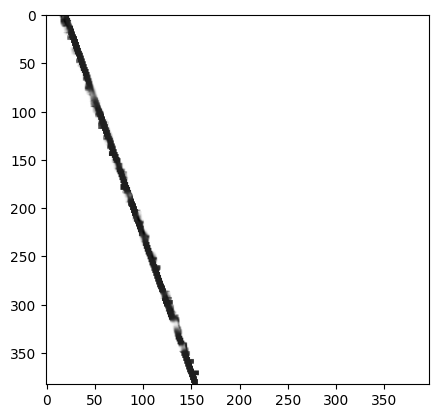

In [57]:
plt.imshow(SSIM_map, cmap="gray")

In [58]:
print(MSSIM)

0.9802452753681098
